# Chapter 7 - Recurrent Neural Networks
***

In [1]:
from collections import Counter
from collections import Counter
from typing import List, Dict, Tuple, Union, Optional
import json
from bs4 import BeautifulSoup
import string
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Functions

In [2]:
# remove these words
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

# remove punctuation
table = str.maketrans('', '', string.punctuation)


# Assuming the tokenize function is defined elsewhere
def tokenize(text):
    # Tokenization logic, removing HTML and stopwords as discussed earlier
    soup = BeautifulSoup(text, "html.parser")
    cleaned_text = soup.get_text()
    tokens = cleaned_text.lower().split()
    filtered_tokens = [token for token in tokens if token not in stopwords]
    return filtered_tokens


def build_vocab(sentences, max_vocab_size: Optional[int] = None):
    counter = Counter()
    for text in sentences:
        counter.update(tokenize(text))

    if max_vocab_size is None:
        # Sort words by frequency in descending order
        words = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    else:
        # Take only the top max_vocab_size-1 most frequent words (leave room for special tokens)
        words = counter.most_common(max_vocab_size - 2)  # -2 for <pad> and <unk>

    # Create vocabulary with indices starting from 2
    vocab = {word: idx + 2 for idx, (word, _) in enumerate(words)}
    vocab['<pad>'] = 0  # Add padding token
    if max_vocab_size is not None:
        vocab['<unk>'] = 1  # Add unknown token
    return vocab


def texts_to_sequences(sentences, word_index):
    sequences = []
    for sentence in sentences:
        sequence = []
        for word in tokenize(sentence):
            # Use unknown token (1) for words not in vocabulary
            sequence.append(word_index.get(word, 1))
        sequences.append(sequence)
    return sequences


def pad_sequences(sequences, max_len):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_len:
            padded_seq = seq[:max_len]
        else:
            padded_seq = seq + [0] * (max_len - len(seq))
        padded_sequences.append(padded_seq)
    return padded_sequences

def word_frequency(sentences, word_dict):
    frequency = {word: 0 for word in word_dict}

    for sentence in sentences:
        words = sentence.lower().split()
        for word in words:
            if word in frequency:
                frequency[word] += 1

    return frequency


def plot_training_metrics(train_loss, train_acc, val_loss, val_acc):
    """
    Plot training and validation metrics on two subplots.

    Args:
        train_loss: Array of training loss values
        train_acc: Array of training accuracy values
        val_loss: Array of validation loss values
        val_acc: Array of validation accuracy values
    """
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot epochs on x-axis
    epochs = range(1, len(train_loss) + 1)

    # First subplot: Loss
    ax1.plot(epochs, train_loss, 'b-', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Second subplot: Accuracy
    ax2.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    # Add accuracy percentage labels
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Adjust layout to prevent overlap
    plt.tight_layout()

    return fig

## Configuration

In [15]:
max_vocab_size = 2000
embedding_dim = 7
max_length = 85
training_size = 23000
batch_size = 32
num_epochs = 300

## Data

### Download

In [4]:
path_data = Path('/tmp/sarcasm.json')

if path_data.is_file() is False:
    !wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json
else:
    print(f'{path_data} already exists.')

/tmp/sarcasm.json already exists.


### Preprocess

In [ ]:
# load the data
with open(path_data, 'r') as f:
    datastore = json.load(f)

# extract cleaned sentences, labels and URL
sentences = []
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

### Tokenize

In [6]:
# define train and test samples
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

# on the train sample: build vocabulary, and create padded sequences
word_index = build_vocab(training_sentences, max_vocab_size=max_vocab_size)
training_sequences = texts_to_sequences(training_sentences, word_index)
training_padded = pad_sequences(training_sequences, max_len=max_length)

# on the test sample: create padded sequences
testing_sequences = texts_to_sequences(testing_sentences, word_index)
testing_padded = pad_sequences(testing_sequences, max_len=max_length)

# compute word frequency
word_freq = word_frequency(training_sentences, word_index)
print(word_freq)

{'new': 1318, 'trump': 1117, 'man': 1075, 'not': 634, 'just': 501, 'will': 484, 'one': 469, 'year': 440, 'report': 434, 'area': 421, 'donald': 407, 'day': 398, 'u': 398, 's': 392, 'can': 387, 'says': 385, 'woman': 378, 'first': 376, 'time': 365, 'like': 356, 'no': 352, 'get': 346, 'old': 332, 'trumps': 331, 'off': 326, 'now': 325, 'life': 319, 'obama': 317, 'people': 311, 'house': 290, 'women': 289, 'white': 281, 'back': 278, 'still': 276, 'make': 275, 'clinton': 264, '5': 260, 'world': 251, 'americans': 246, 'years': 240, 'way': 239, 'family': 231, 'black': 230, 'study': 225, 'gop': 218, 'best': 215, 'bill': 211, 'american': 208, 'school': 207, 'police': 206, 'watch': 206, '3': 205, 'show': 205, 'really': 200, 'president': 198, 'home': 196, 'last': 194, 'video': 194, 'finds': 194, 'death': 193, 'cant': 193, 'know': 193, '10': 192, 'things': 191, 'good': 191, 'going': 190, 'state': 189, 'hillary': 187, 'love': 184, 'nation': 177, 'may': 174, '2': 174, 'health': 172, 'say': 172, 'parent

In [7]:
xs=[]
ys=[]
current_item=1
for item in sentences:
  xs.append(current_item)
  current_item=current_item+1
  ys.append(len(item))
newys = sorted(ys)

#plt.plot(xs,newys)
#plt.axis([20000, 27000, 50, 250])
#plt.show()

#print(newys[20000])

### `DataLoader`

In [ ]:
# Convert your preprocessed data to PyTorch tensors
training_padded = torch.tensor(training_padded, dtype=torch.long)
testing_padded = torch.tensor(testing_padded, dtype=torch.long)
training_labels = torch.tensor(training_labels, dtype=torch.float32)
testing_labels = torch.tensor(testing_labels, dtype=torch.float32)

# Create DataLoader objects
train_dataset = TensorDataset(training_padded, training_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(testing_padded, testing_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Model

In [ ]:
class TextClassificationModel(nn.Module):
    def __init__(
            self, 
            vocab_size, 
            embedding_dim, 
            hidden_dim=24, 
            lstm_layers=1,
            dropout_rate=0
            ):
        super(TextClassificationModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # FIrst LSTM layer
        self.lstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )

        # Second LSTM layer
        self.lstm2 = nn.LSTM(
            input_size=hidden_dim * 2, # because the previous LSTM layer is bidirectional
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True
        )

        # dropout layers
        self.embedding_dropout = nn.Dropout(dropout_rate)
        self.lstm_dropout = nn.Dropout(dropout_rate)
        self.final_dropout = nn.Dropout(dropout_rate)

        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, sequence_length)

        # Get embeddings
        embedded = self.embedding_dropout(self.embedding(x))  # Shape: (batch_size, sequence_length, embedding_dim)

        # Pass through LSTM
        lstm1_out, _ = self.lstm1(embedded)  # Shape: (batch_size, sequence_length, hidden_dim * 2)
        lstm1_out = self.lstm_dropout(lstm1_out)

        # Pass through second LSTM
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.final_dropout(lstm2_out)

        # Transpose for global pooling (expecting: batch, channels, sequence_length)
        lstm_out = lstm2_out.transpose(1, 2)  # Shape: (batch_size, hidden_dim * 2, sequence_length)

        # Apply global pooling
        pooled = self.global_pool(lstm_out)  # Shape: (batch_size, hidden_dim * 2, 1)
        pooled = pooled.squeeze(-1)  # Shape: (batch_size, hidden_dim * 2)

        # Pass through fully connected layers
        x = self.relu(self.fc1(pooled))
        x = self.sigmoid(self.fc2(x))

        return x

In [25]:
# Model parameters
vocab_size = len(word_index)

# Create the model
model = TextClassificationModel(vocab_size, embedding_dim)
model = model.to(device)

summary(model,
        input_size=(batch_size, max_length),
        dtypes=[torch.long],  # Specify long dtype for embedding layer
        device=device)

Layer (type:depth-idx)                   Output Shape              Param #
TextClassificationModel                  [32, 1]                   --
├─Embedding: 1-1                         [32, 85, 7]               14,000
├─Dropout: 1-2                           [32, 85, 7]               --
├─LSTM: 1-3                              [32, 85, 48]              6,336
├─Dropout: 1-4                           [32, 85, 48]              --
├─LSTM: 1-5                              [32, 85, 48]              14,208
├─Dropout: 1-6                           [32, 85, 48]              --
├─AdaptiveAvgPool1d: 1-7                 [32, 48, 1]               --
├─Linear: 1-8                            [32, 24]                  1,176
├─ReLU: 1-9                              [32, 24]                  --
├─Linear: 1-10                           [32, 1]                   25
├─Sigmoid: 1-11                          [32, 1]                   --
Total params: 35,745
Trainable params: 35,745
Non-trainable params: 0
T

### Train

In [26]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999), amsgrad=False)

In [27]:
# Training loop
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_total += targets.size(0)
        train_correct += ((outputs.squeeze() > 0.5) == targets).sum().item()

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)

            val_loss += loss.item()
            val_total += targets.size(0)
            val_correct += ((outputs.squeeze() > 0.5) == targets).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}:')
    train_loss_history.append(train_loss/len(train_loader))
    train_acc_history.append(train_correct/train_total)
    val_loss_history.append(val_loss/len(test_loader))
    val_acc_history.append(val_correct/val_total)
    print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_correct/train_total:.4f}')
    print(f'Val Loss: {val_loss/len(test_loader):.4f}, Val Acc: {val_correct/val_total:.4f}')

Epoch 1/300:
Train Loss: 0.6870, Train Acc: 0.5536
Val Loss: 0.6831, Val Acc: 0.5700
Epoch 2/300:
Train Loss: 0.6857, Train Acc: 0.5596
Val Loss: 0.6830, Val Acc: 0.5700
Epoch 3/300:
Train Loss: 0.6855, Train Acc: 0.5596
Val Loss: 0.6837, Val Acc: 0.5700
Epoch 4/300:
Train Loss: 0.6858, Train Acc: 0.5596
Val Loss: 0.6831, Val Acc: 0.5700
Epoch 5/300:
Train Loss: 0.6857, Train Acc: 0.5596
Val Loss: 0.6829, Val Acc: 0.5700
Epoch 6/300:
Train Loss: 0.6854, Train Acc: 0.5596
Val Loss: 0.6826, Val Acc: 0.5700
Epoch 7/300:
Train Loss: 0.6755, Train Acc: 0.5747
Val Loss: 0.6572, Val Acc: 0.6083
Epoch 8/300:
Train Loss: 0.6575, Train Acc: 0.6076
Val Loss: 0.6499, Val Acc: 0.6174
Epoch 9/300:
Train Loss: 0.6495, Train Acc: 0.6180
Val Loss: 0.6443, Val Acc: 0.6287
Epoch 10/300:
Train Loss: 0.6438, Train Acc: 0.6250
Val Loss: 0.6403, Val Acc: 0.6387
Epoch 11/300:
Train Loss: 0.6384, Train Acc: 0.6339
Val Loss: 0.6396, Val Acc: 0.6449
Epoch 12/300:
Train Loss: 0.6329, Train Acc: 0.6378
Val Loss: 0

### Analyse results

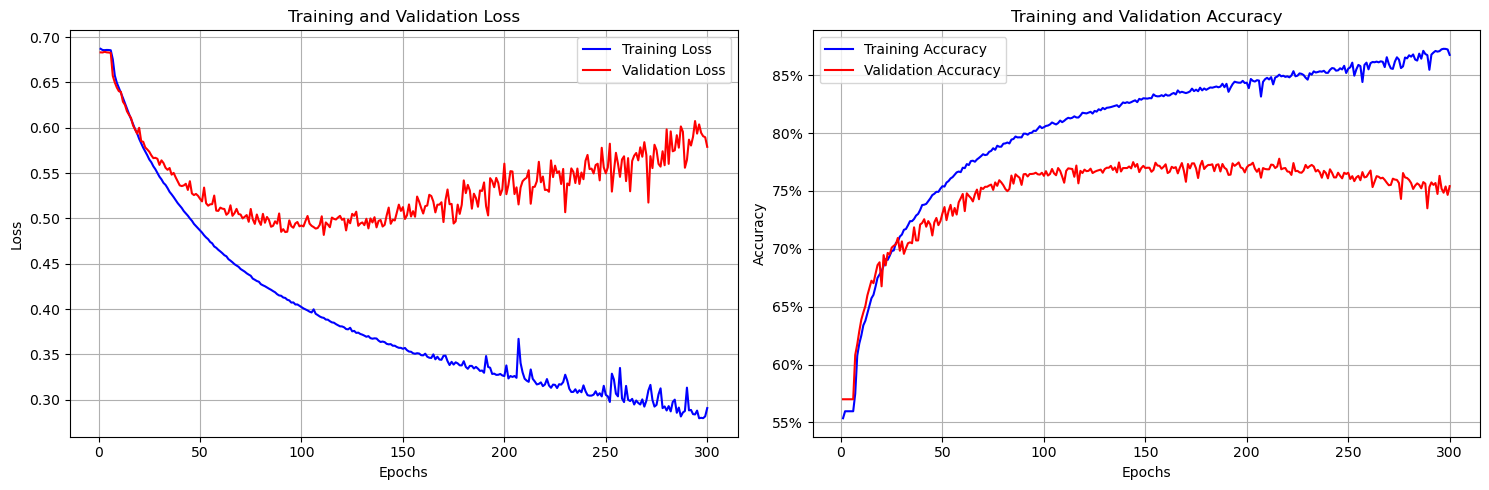

In [29]:
_ = plot_training_metrics(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

In [ ]:
# After training, you can save the model
torch.save(model.state_dict(), 'text_classification_model.pth')

### Inference

In [ ]:
print(word_index)
print(texts_to_sequences(test_sentences, word_index))

In [ ]:
def predict_sentences(model, sentences, vocab, max_len, device='cuda', threshold=0.5):
    """
    Make predictions for new sentences and interpret results
    """
    # Preprocess
    sequences = texts_to_sequences(sentences, vocab)
    padded = pad_sequences(sequences, max_len)
    #print(padded)

    # Convert to tensor
    input_ids = torch.tensor(padded, dtype=torch.long).to(device)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids)
        print(outputs)
        probabilities = outputs.squeeze().cpu().numpy()
        predictions = (probabilities >= threshold).astype(int)

    # Print results
    for sentence, prob, pred in zip(sentences, probabilities, predictions):
        print(f"\nText: {sentence}")
        print(f"Probability: {prob:.4f}")
        print(f"Classification: {'Sarcastic' if pred == 1 else 'Not Sarcastic'}")
        print(f"Confidence: {max(prob, 1-prob):.4f}")
        print("-" * 80)

test_sentences = ["granny starting to fear spiders in the garden might be real",
             "game of thrones season finale showing this sunday night",
             "PyTorch book will be a best seller"]

# Example usage:
model = model.to(device)
predict_sentences(
    model=model,
    sentences=test_sentences,
    vocab=word_index,
    max_len=85,
    threshold=0.5  # Adjust this threshold if needed
)


In [ ]:
reverse_word_index = dict([(value, key)
for (key, value) in word_index.items()])

In [ ]:
# Get the embedding weights as a numpy array
embedding_weights = model.embedding.weight.data.cpu().numpy()
print(embedding_weights.shape)

# If you want to see the embedding for a specific word:
def get_word_embedding(word, vocab, model):
    if word in vocab:
        word_idx = vocab[word]
        return model.embedding.weight.data[word_idx].cpu().numpy()
    else:
        return None

# Example usage:
word = "game"
embedding = get_word_embedding(word, word_index, model)
if embedding is not None:
    print(f"Embedding for '{word}': {embedding}")
    print(f"Embedding dimension: {len(embedding)}")
else:
    print(f"Word '{word}' not found in vocabulary")

# If you want to save all embeddings with their corresponding words:
word_embeddings = {}
for word, idx in word_index.items():
    word_embeddings[word] = model.embedding.weight.data[idx].cpu().numpy()

In [ ]:
print(reverse_word_index[2])
print(embedding_weights[2])

In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = embedding_weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')